In [21]:
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import operator

In [22]:
# HELPER FUNCTIONS

def compute_metric(predy, y, arg, d=1):
    meany = np.sum(np.array(y))
    temp = np.array([i-meany for i in y])
    tss = np.sum(np.multiply(temp, temp))
    
    #meanpredy = np.sum(np.array(predy))
    temp = np.array([y[i]-predy[i] for i in range(len(y))])
    rss = np.sum(np.multiply(temp, temp))
    
    var = lambda ya,yp: np.var(np.array(ya) - np.array(yp))
    
    n = len(predy)
    sig2 = var(y,predy)
    
    rsquare = lambda rss,tss: (float(tss)-float(rss))/float(tss)
    cp = lambda rss,d,sig2,n: (float(rss)+float(2*d)*float(sig2))/float(n)
    aic = lambda rss,d,sig2,n: (float(rss)+float(2*d)*float(sig2))/(float(n)*float(sig2))
    bic = lambda rss,d,sig2,n: (float(rss)+math.log(float(n))*float(d)*float(sig2))/(float(n)*float(sig2))

    if arg == 'rsquare':
        return rsquare(rss,tss)
    elif arg == 'cp':
        return cp(rss,d,sig2,n)
    elif arg == 'aic':
        return aic(rss,d,sig2,n)
    elif arg == 'bic':
        return bic(rss,d,sig2,n)
    else:
        return rss
    
def feat_formation(data, feat, curfeat):
    temp = data.tolist()
    temp_feat = [i for i in feat]
    temp_feat.append(curfeat)
    out = np.array([[sample[i] for i in temp_feat] for sample in temp])
    #print 'out1'
    #print out
    return out

def feat_formation_backward(data, feat, curfeat):
    tempq = data.tolist()
    temp = [i for i in tempq]
    temp_feat = [i for i in feat]
    temp_feat.remove(curfeat)
    out = np.array([[sample[i] for i in temp_feat] for sample in temp])
    return out

def feat_formation_best(data, feat):
    temp = data.tolist()
    temp_feat = [i for i in feat]
    out = np.array([[sample[i] for i in temp_feat] for sample in temp])
    return out

In [23]:
def stepwise_forward_selection(train_data, test_data, train_labels, test_labels, feat_names):
    #train_data, val_data, train_labels, val_labels = train_test_split(train_data,
                                                                      #train_labels,
                                                                      #test_size=0.20)
    
    kf = KFold(n_splits=5)
    kf.get_n_splits(train_data)
    
    selected_feat = []
    leftover_feat = [i for i in range(9)]
    val_error = {}
    test_error = {}
    train_error = {}
    for d in range(9):
        d += 1
        metric = []
        val_err = []
        test_err = []
        train_err = []
        for i in leftover_feat:
            v_err = []
            tr_err = []
            te_err = []
            for train_ind, val_ind in kf.split(train_data):
                train_data1, val_data1 = train_data[train_ind], train_data[val_ind]
                tr_labels, v_labels = train_labels[train_ind], train_labels[val_ind]
                
                tr_data = feat_formation(train_data1, selected_feat, i)
                v_data = feat_formation(val_data1, selected_feat, i)
                te_data = feat_formation(test_data, selected_feat, i)
                lm = linear_model.LinearRegression()
                lm.fit(tr_data, tr_labels)
            
                tr_pred = lm.predict(tr_data)
                te_pred = lm.predict(te_data)
                v_pred = lm.predict(v_data)
                
                v_err.append(compute_metric(v_pred, v_labels, 'rss', d))
                te_err.append(compute_metric(te_pred, test_labels, 'rss', d))
                tr_err.append(compute_metric(tr_pred, tr_labels, 'rss', d))
        
            val_err.append(np.mean(np.array(v_err)))
            test_err.append(np.mean(np.array(te_err)))
            train_err.append(np.mean(np.array(tr_err)))
        selected_ind = np.argmin(np.array(val_err))
        selected_feat.append(leftover_feat[selected_ind])
        leftover_feat.remove(leftover_feat[selected_ind])
        
        selected_feat_str = [str(i) for i in selected_feat]
        model_name = ','.join(selected_feat_str)
        val_error[model_name] = val_err[selected_ind]
        test_error[model_name] = test_err[selected_ind]
        train_error[model_name] = train_err[selected_ind]
    return selected_feat, train_error, val_error, test_error

In [24]:
# stepwise backward selection
def stepwise_backward_elimination(train_data, test_data, train_labels, test_labels, feat_names):
    kf = KFold(n_splits=5)
    kf.get_n_splits(train_data)
    
    selected_feat = []
    leftover_feat = [i for i in range(9)]
    val_error = {}
    test_error = {}
    train_error = {}
    for d in range(9):
        d += 1
        metric = []
        val_err = []
        test_err = []
        train_err = []
        for i in leftover_feat:
            if len(leftover_feat) == 1:
                break
            v_err = []
            tr_err = []
            te_err = []
            for train_ind, val_ind in kf.split(train_data):
                train_data1, val_data1 = train_data[train_ind], train_data[val_ind]
                tr_labels, v_labels = train_labels[train_ind], train_labels[val_ind]
                
                tr_data = feat_formation_backward(train_data1, leftover_feat, i)
                #print tr_data
                v_data = feat_formation_backward(val_data1, leftover_feat, i)
                te_data = feat_formation_backward(test_data, leftover_feat, i)
                lm = linear_model.LinearRegression()
                lm.fit(tr_data, tr_labels)
            
                tr_pred = lm.predict(tr_data)
                te_pred = lm.predict(te_data)
                v_pred = lm.predict(v_data)
                
                v_err.append(compute_metric(v_pred, v_labels, 'rss', d))
                te_err.append(compute_metric(te_pred, test_labels, 'rss', d))
                tr_err.append(compute_metric(tr_pred, tr_labels, 'rss', d))
        
            val_err.append(np.mean(np.array(v_err)))
            test_err.append(np.mean(np.array(te_err)))
            train_err.append(np.mean(np.array(tr_err)))
        if len(leftover_feat) == 1:
            break
        #print valerr
        selected_ind = np.argmin(np.array(val_err))
        selected_feat.append(leftover_feat[selected_ind])
        leftover_feat.remove(leftover_feat[selected_ind])
        
        leftover_feat_str = [str(i) for i in leftover_feat]
        model_name = ','.join(leftover_feat_str)
        val_error[model_name] = val_err[selected_ind]
        test_error[model_name] = test_err[selected_ind]
        train_error[model_name] = train_err[selected_ind]
    return selected_feat, train_error, val_error, test_error

Sorted Forward Selection
Selection order ['Bare Nuclei', 'Uniformity of cell size', 'clump thickness', 'Normal Nucleoli', 'Uniformity of cell shape', 'Bland chromatin', 'Single epithelial cell size', 'Marginal adhesion', 'Mitoses']
[('5,1,0,7,2,6,4,3,8', 61.63289274633214), ('5,1,0,7,2,6,4,3', 61.701257186775095), ('5,1,0,7,2,6,4', 62.68482690009675), ('5,1,0,7,2,6', 62.78103119027717), ('5,1,0,7,2', 63.56991064414236), ('5,1,0,7', 64.87559737077194), ('5,1,0', 69.35255269066204), ('5,1', 77.20869622666991), ('5', 118.73887034348186)]
[('5,1,0,7,2,6', 16.391664572484597), ('5,1,0,7,2,6,4', 16.44067475356248), ('5,1,0,7,2,6,4,3', 16.5219774685196), ('5,1,0,7,2,6,4,3,8', 16.62275434997828), ('5,1,0,7,2', 16.65160392165879), ('5,1,0,7', 16.974109784423685), ('5,1,0', 18.099285098872308), ('5,1', 20.011025326208987), ('5', 29.893145976248103)]
[('5,1,0,7,2,6,4', 20.068495007330807), ('5,1,0,7,2,6', 20.40134542694671), ('5,1,0,7,2,6,4,3', 20.6298240847999), ('5,1,0,7,2,6,4,3,8', 20.67352401

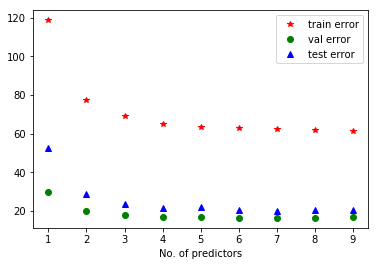


Sorted Backward Elimination
Elimination order ['Mitoses', 'Marginal adhesion', 'Single epithelial cell size', 'Bland chromatin', 'Uniformity of cell shape', 'Normal Nucleoli', 'clump thickness', 'Uniformity of cell size']
[('0,1,2,3,4,5,6,7', 61.70125718677508), ('0,1,2,4,5,6,7', 62.68482690009675), ('0,1,2,5,6,7', 62.78103119027717), ('0,1,2,5,7', 63.56991064414236), ('0,1,5,7', 64.87559737077196), ('0,1,5', 69.35255269066205), ('1,5', 77.20869622666991), ('5', 118.73887034348186)]
[('0,1,2,5,6,7', 16.391664572484597), ('0,1,2,4,5,6,7', 16.440674753562476), ('0,1,2,3,4,5,6,7', 16.521977468519594), ('0,1,2,5,7', 16.651603921658786), ('0,1,5,7', 16.974109784423685), ('0,1,5', 18.099285098872308), ('1,5', 20.011025326208987), ('5', 29.893145976248103)]
[('0,1,2,4,5,6,7', 20.068495007330807), ('0,1,2,5,6,7', 20.401345426946705), ('0,1,2,3,4,5,6,7', 20.629824084799896), ('0,1,5,7', 21.331274741844), ('0,1,2,5,7', 21.838046775451183), ('0,1,5', 23.544396580691085), ('1,5', 28.6469482062243

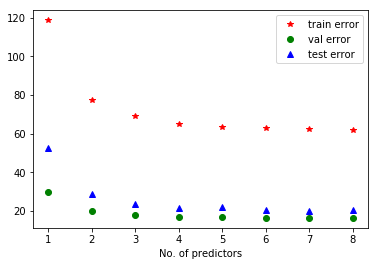

In [25]:
# MAIN CODE FOR RUNNING STEPWISE FORWARD AND BACKWARD ELIMINATION
np.random.seed(12)
df = pd.read_csv('hw2_question1.csv')
temp = np.array(df.values.tolist())
ind = [i for i in range(9)]
train_data, test_data, train_labels, test_labels = train_test_split(temp[:,ind], 
                                                                    temp[:,9], 
                                                                    test_size=0.20)
feat_names = df.keys()[:-1]
(selected_feat, train_error, val_error, test_error) = stepwise_forward_selection(train_data,
                                                                                 test_data,
                                                                                 train_labels,
                                                                                 test_labels,
                                                                                 feat_names)
print 'Sorted Forward Selection'
print 'Selection order ' + str([df.keys()[i] for i in selected_feat])
print sorted(train_error.items(), key=operator.itemgetter(1))
print sorted(val_error.items(), key=operator.itemgetter(1))
print sorted(test_error.items(), key=operator.itemgetter(1))

plt.figure()
plt.plot([len(i.split(',')) for i in train_error.keys()], train_error.values(), 'r*', label='train error')
plt.plot([len(i.split(',')) for i in val_error.keys()], val_error.values(), 'go', label='val error')
plt.plot([len(i.split(',')) for i in test_error.keys()], test_error.values(), 'b^', label='test error')
plt.xlabel('No. of predictors')
plt.legend()
plt.show()

feat_names = df.keys()[:-1]
(selected_feat, train_error, val_error, test_error) = stepwise_backward_elimination(train_data,
                                                                                    test_data,
                                                                                    train_labels,
                                                                                    test_labels,
                                                                                    feat_names)
print ''
print 'Sorted Backward Elimination'
print 'Elimination order ' + str([df.keys()[i] for i in selected_feat])
print sorted(train_error.items(), key=operator.itemgetter(1))
print sorted(val_error.items(), key=operator.itemgetter(1))
print sorted(test_error.items(), key=operator.itemgetter(1))


plt.figure()
plt.plot([len(i.split(',')) for i in train_error.keys()], train_error.values(), 'r*', label='train error')
plt.plot([len(i.split(',')) for i in val_error.keys()], val_error.values(), 'go', label='val error')
plt.plot([len(i.split(',')) for i in test_error.keys()], test_error.values(), 'b^', label='test error')
plt.xlabel('No. of predictors')
plt.legend()
plt.show()

In [26]:
# best subset selection
#def all_substrings(allfeat_string):
#    l = len(allfeat_string)
#    return [list(allfeat_string[i:j+1]) for i in xrange(l) for j in xrange(i,l)]
from itertools import combinations

comb1 = list(combinations([0,1,2,3,4,5,6,7,8], 1))
comb2 = list(combinations([0,1,2,3,4,5,6,7,8], 2))
comb3 = list(combinations([0,1,2,3,4,5,6,7,8], 3))
comb4 = list(combinations([0,1,2,3,4,5,6,7,8], 4))
comb5 = list(combinations([0,1,2,3,4,5,6,7,8], 5))
comb6 = list(combinations([0,1,2,3,4,5,6,7,8], 6))
comb7 = list(combinations([0,1,2,3,4,5,6,7,8], 7))
comb8 = list(combinations([0,1,2,3,4,5,6,7,8], 8))
comb9 = list(combinations([0,1,2,3,4,5,6,7,8], 9))

comb = list()
for i in comb1:
    comb.append(i)
for i in comb2:
    comb.append(i)
for i in comb3:
    comb.append(i)
for i in comb4:
    comb.append(i)
for i in comb5:
    comb.append(i)
for i in comb6:
    comb.append(i)
for i in comb7:
    comb.append(i)
for i in comb8:
    comb.append(i)
for i in comb9:
    comb.append(i)
    
all_models = comb#all_substrings('012345678')
kf = KFold(n_splits=5)
kf.get_n_splits(train_data)

val_error = {}
test_error = {}
train_error = {}
for predictors in all_models:
    predictors = list(predictors)
    predictors = [str(i) for i in predictors]
    v_err = []
    tr_err = []
    te_err = []
    selected_feat = [int(i) for i in predictors]
    for train_ind, val_ind in kf.split(train_data):
        train_data1, val_data1 = train_data[train_ind], train_data[val_ind]
        tr_labels, v_labels = train_labels[train_ind], train_labels[val_ind]
        
        tr_data = feat_formation_best(train_data1, selected_feat)
        v_data = feat_formation_best(val_data1, selected_feat)
        te_data = feat_formation_best(test_data, selected_feat)
        lm = linear_model.LinearRegression()
        lm.fit(tr_data, tr_labels)
            
        tr_pred = lm.predict(tr_data)
        te_pred = lm.predict(te_data)
        v_pred = lm.predict(v_data)
        
        d = len(predictors)
        v_err.append(compute_metric(v_pred, v_labels, 'rss', d))
        te_err.append(compute_metric(te_pred, test_labels, 'rss', d))
        tr_err.append(compute_metric(tr_pred, tr_labels, 'rss', d))
    
    model_name = ','.join(predictors)
    val_error[model_name] = np.mean(np.array(v_err))
    test_error[model_name] = np.mean(np.array(te_err))
    train_error[model_name] = np.mean(np.array(tr_err))

print 'Sorted Best Subset'
print sorted(train_error.items(), key=operator.itemgetter(1))
print ''
print sorted(val_error.items(), key=operator.itemgetter(1))
print ''
print sorted(test_error.items(), key=operator.itemgetter(1))

Sorted Best Subset
[('0,1,2,3,4,5,6,7,8', 61.63289274633214), ('0,1,2,3,5,6,7,8', 61.70061578464087), ('0,1,2,3,4,5,6,7', 61.70125718677508), ('0,1,2,3,5,6,7', 61.771019350046664), ('0,1,2,3,4,5,7,8', 62.20802335463732), ('0,1,2,3,4,5,7', 62.2705559595063), ('0,1,2,3,5,7,8', 62.27967740722291), ('0,1,2,3,5,7', 62.34284779336417), ('0,1,2,4,5,6,7,8', 62.528636751596274), ('0,1,2,5,6,7,8', 62.60339638295127), ('0,1,3,4,5,6,7,8', 62.60641595895991), ('0,1,2,4,5,6,7', 62.68482690009675), ('0,1,3,4,5,6,7', 62.703290158687466), ('0,1,3,5,6,7,8', 62.70977105854928), ('0,1,2,5,6,7', 62.78103119027717), ('0,1,3,5,6,7', 62.821921007332286), ('0,2,3,4,5,6,7,8', 62.95654913899134), ('0,2,3,4,5,6,7', 63.01948885342252), ('0,2,3,5,6,7,8', 63.19224196248107), ('0,1,3,4,5,7,8', 63.246919174944196), ('0,2,3,5,6,7', 63.27228160405008), ('0,1,2,4,5,7,8', 63.30972443582402), ('0,1,3,4,5,7', 63.33544682954422), ('0,1,3,5,7,8', 63.35876936553241), ('0,1,2,5,7,8', 63.39230651953327), ('0,1,3,5,7', 63.4609320

In [49]:
val = []
key = []
for k,v in test_error.items():
    if len(k.split(',')) == 8:
        val.append(v)
        key.append(k)

i = np.argmin(np.array(val))
print val[i]
print key[i]

20.23326748850915
0,1,2,4,5,6,7,8


In [41]:
df.keys()

Index([u'clump thickness', u'Uniformity of cell size',
       u'Uniformity of cell shape', u'Marginal adhesion',
       u'Single epithelial cell size', u'Bare Nuclei', u'Bland chromatin',
       u'Normal Nucleoli', u'Mitoses', u'Class'],
      dtype='object')

In [20]:
train_error

{'0,1,2,3,4,5,6,7': 61.70125718677508,
 '0,1,2,4,5,6,7': 62.68482690009675,
 '0,1,2,5,6,7': 62.78103119027717,
 '0,1,2,5,7': 63.56991064414236,
 '0,1,5': 69.35255269066205,
 '0,1,5,7': 64.87559737077196,
 '1,5': 77.20869622666991,
 '5': 118.73887034348186}

In [241]:
test_error

{'0,1,2,4,5,6,7,8': 22.79683113792027,
 '0,1,4,5,6,7': 23.054032316447294,
 '0,1,4,5,6,7,8': 23.047420772282074,
 '0,1,5': 26.628604900643815,
 '0,1,5,6,7': 22.858658167533722,
 '0,1,5,7': 24.0303909742646,
 '1,5': 30.220074769519908,
 '5': 47.78299194494644}

In [243]:
test_error

{'0': 57.10421049834556,
 '0,1': 33.14892153728327,
 '0,1,2': 32.564657053738564,
 '0,1,2,3': 28.937150155522982,
 '0,1,2,3,4': 27.790890980944077,
 '0,1,2,3,4,5': 25.39540628396595,
 '0,1,2,3,4,5,6': 24.006001921504424,
 '0,1,2,3,4,5,6,7': 22.60051616795034,
 '0,1,2,3,4,5,6,7,8': 22.650976282453144,
 '0,1,2,3,4,5,6,8': 24.012336019068737,
 '0,1,2,3,4,5,7': 23.481099045671222,
 '0,1,2,3,4,5,7,8': 23.532214452898508,
 '0,1,2,3,4,5,8': 25.436593117831737,
 '0,1,2,3,4,6': 24.135947006694078,
 '0,1,2,3,4,6,7': 22.595547808529005,
 '0,1,2,3,4,6,7,8': 22.968247401550478,
 '0,1,2,3,4,6,8': 24.51856385021002,
 '0,1,2,3,4,7': 25.2685231239453,
 '0,1,2,3,4,7,8': 25.489654620502996,
 '0,1,2,3,4,8': 28.088807283817232,
 '0,1,2,3,5': 25.659115060444822,
 '0,1,2,3,5,6': 24.102078408114465,
 '0,1,2,3,5,6,7': 22.51119894161983,
 '0,1,2,3,5,6,7,8': 22.543380114502135,
 '0,1,2,3,5,6,8': 24.023038202939627,
 '0,1,2,3,5,7': 23.469479731351385,
 '0,1,2,3,5,7,8': 23.533267950330174,
 '0,1,2,3,5,8': 25.65139